# Eksploratorna analiza

Izvršit ćemo neke jednostavnije analize odabranog skupa podataka kako bismo vidjeli kakvim podatcima raspolažemo, te eventualno uočili neka pravila ili međusobne ovisnosti svojstava i ishoda. Također, želimo provjeriti neke tvrdnje koje smatramo zanimljivima i korisnima za daljnje istraživanje.

In [23]:
# import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from scipy import stats
import seaborn as sns
%matplotlib inline

In [5]:
df=pd.read_csv("C:/Users/Matko/Documents/hotel_bookings.csv")

In [6]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [7]:
df.isnull().sum().sort_values(ascending=False)[:10]

company                     112593
agent                        16340
country                        488
children                         4
lead_time                        0
arrival_date_year                0
arrival_date_month               0
arrival_date_week_number         0
is_canceled                      0
market_segment                   0
dtype: int64

In [76]:
##Izbacimo redove u kojima su rezervacije sa 0 osoba
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)
## Zamjenimo null vrijednosti s 0 za agent, company i children.
df[['agent','company', 'children']] = df[['agent','company', 'children']].fillna(0.0)
## Tamo gdje nema vrijednosti za country, zamjenimo sa mode
df['country'].fillna(df.country.mode().to_string(), inplace=True)

In [148]:
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

In [181]:
##Stvaramo nove varijable iz postojećih da lakše analiziramo odnose
df['is_children'] = ['Y' if x > 0 else 'N' for x in df['children']]
df['is_baby'] = ['Y' if x > 0 else 'N' for x in df['babies']]
df['is_agent'] = ['Y' if x > 0 else 'N' for x in df['agent']]
df['is_company'] = ['Y' if x > 0 else 'N' for x in df['company']]
df['is_parking'] = ['Y' if x > 0 else 'N' for x in df['required_car_parking_spaces']]
df['is_request'] = ['Y' if x > 0 else 'N' for x in df['total_of_special_requests']]
df['is_canceled_before'] = ['Y' if x > 0 else 'N' for x in df['previous_cancellations']]
df['is_changed'] = ['Y' if x > 0 else 'N' for x in df['booking_changes']]
df['is_waited'] = ['Y' if x > 0 else 'N' for x in df['days_in_waiting_list']]
df['is_room_changed'] = df[['reserved_room_type','assigned_room_type']].apply(lambda x:x['reserved_room_type'] != x['assigned_room_type'], axis=1)

In [102]:
rh = df.loc[(df["hotel"] == "Resort Hotel") & (df["is_canceled"] == 0)]
ch = df.loc[(df["hotel"] == "City Hotel") & (df["is_canceled"] == 0)]

Gledamo odnos ukupnog broja gostiju i otkazivanja posebno za dva tipa hotela.

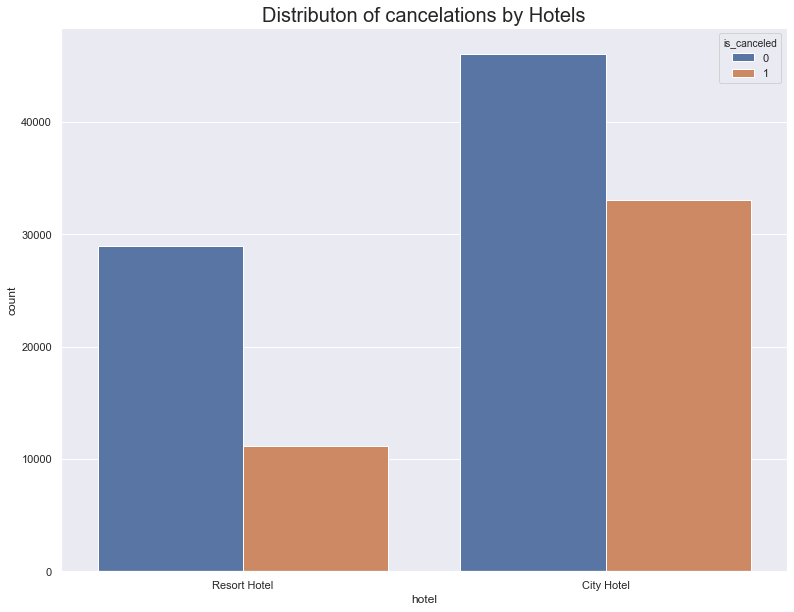

In [192]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Distributon of cancelations by Hotels", fontdict = {'fontsize':20})
ax = sns.countplot(x = "hotel", hue = 'is_canceled', data = df)

Iz grafa vidimo da gradski hoteli ukupno imaju više gostiju, ali i veći postotak otkazanih rezervacija.

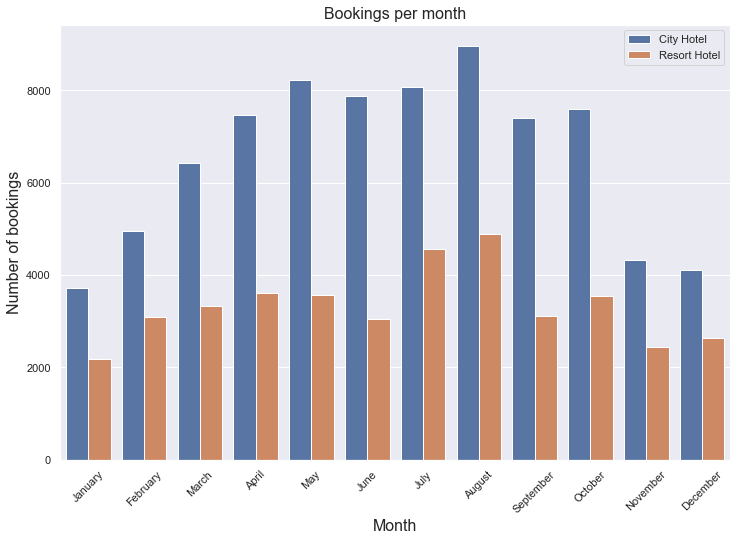

In [191]:
res_book_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "Bookings" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Bookings per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of bookings", fontsize=16)
plt.legend(loc="upper right")
plt.show()

Iz prikaza broja gostiju po mjesecima vidimo da su oba tipa hotela popularnija u ljetnim mjesecima, s tim da resort hoteli imaju manji pad broja gostiju tokom zimskih mjeseci.

Nadalje, provjerit ćemo odnose ostalih varijabli sa brojem otkazivanja.

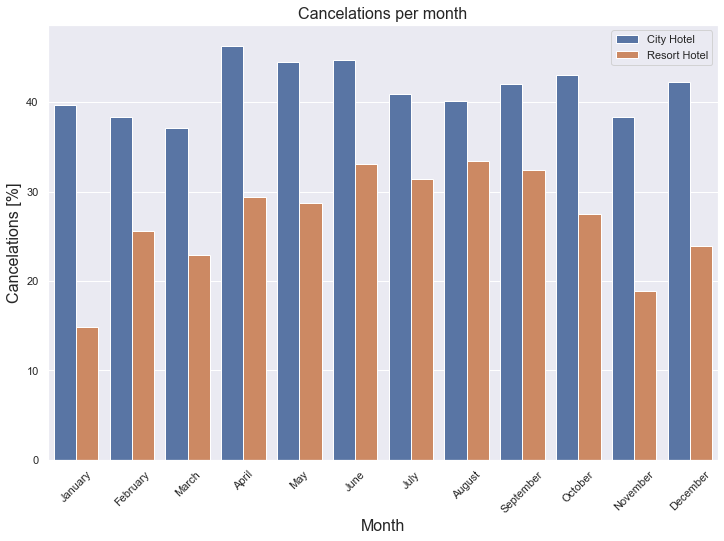

In [190]:
res_book_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

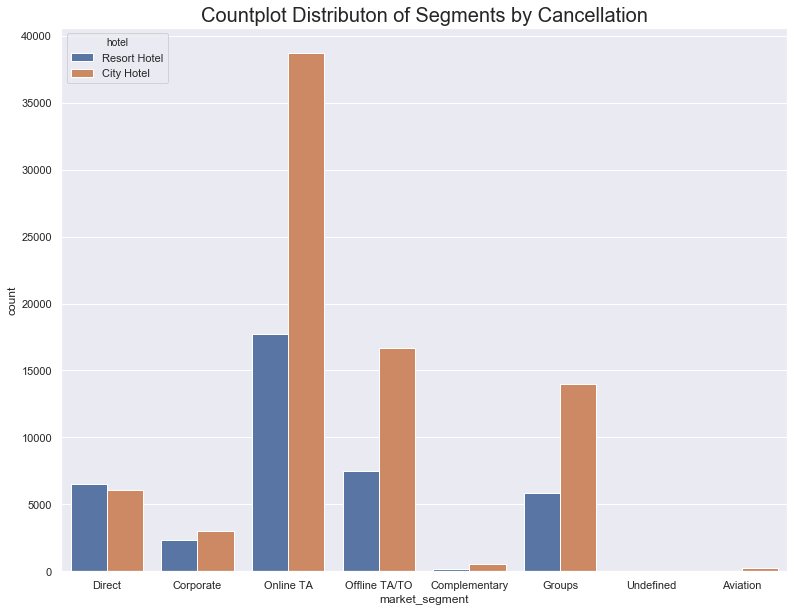

In [196]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of Segments by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'hotel', data = df)

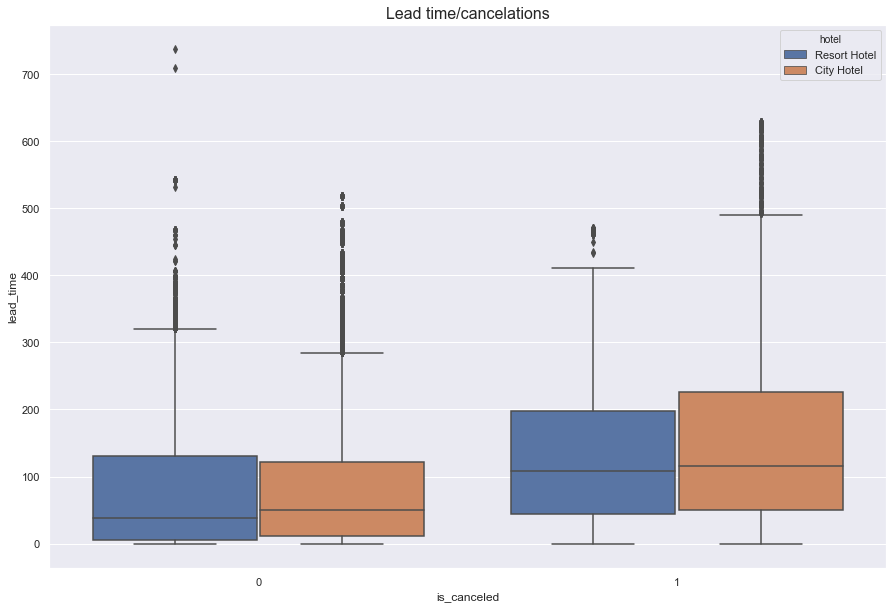

In [232]:
plt.figure(figsize = (15,10))
plt.title("Lead time/cancelations", fontsize=16)
sns.boxplot(x = "is_canceled", y = "lead_time", data = df, hue = "hotel");

U prvom grafu vidimo postotak otkazivanja po mjesecima. Vidljivo je da zimski mjeseci imaju nešto niži postotak otkazivanja, ali je to za gradske hotele zanemarivo, dok je za resorte nešto izraženije. Zaključujemo da gradski hoteli imaju podjednak postotak otkazanih rezervacija tokom cijele godine, dok resorti imaju više otkazivanja u ljetnim mjesecima, to bi nam moglo biti korisno kad ćemo raditi model.

Kad gledamo broj otkazivanja po tipu rezervacije vidimo da se najviše otkazuju rezervacije napravljene preko online sustava. 

Treći graf pokazuje da je za oba tipa hotela otkazivanje vjerojatnije što je više vremena preostalo do rezervacije. Prosječno vrijeme otkazivanje je nešto više od 100 dana do rezervacije.

Pogledajmo sad odnos otkazanih rezervacija sa nekim od varijabli koje smo prethodno kreirali.

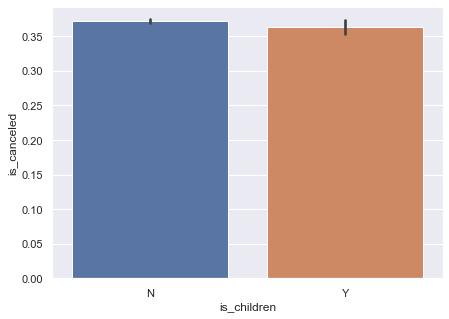

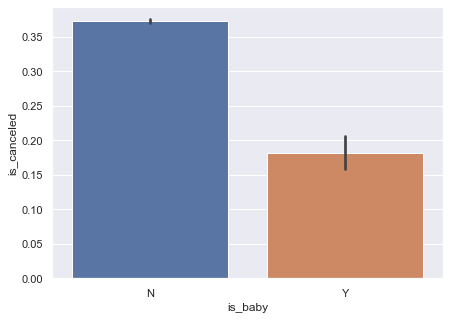

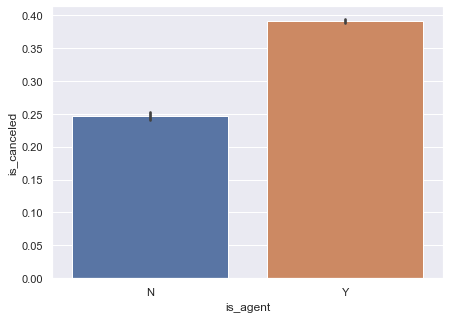

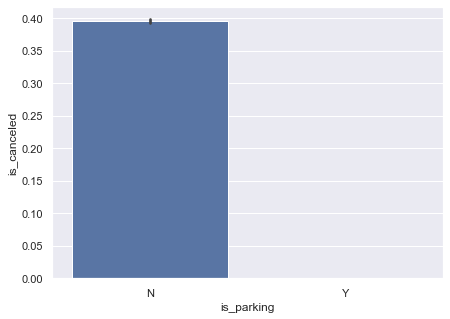

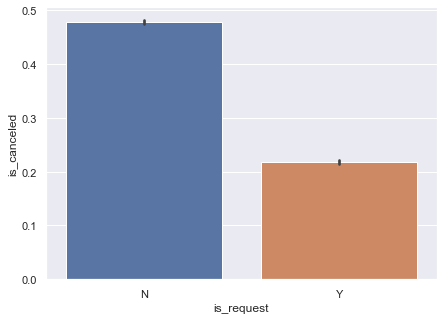

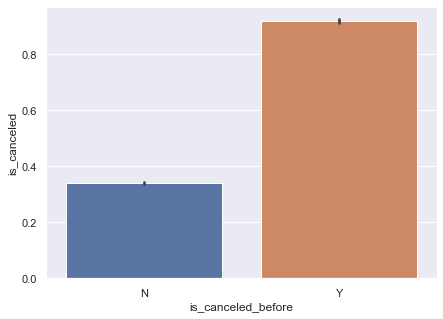

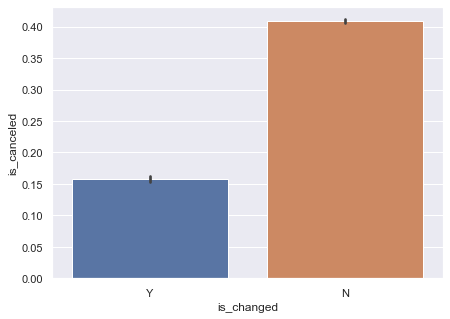

In [231]:
plot(df.is_children, df.is_canceled, x_label=None,y_label='canceled', title=None, figsize=(7,5), type='bar')
plot(df.is_baby, df.is_canceled, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar')
plot(df.is_agent, df.is_canceled, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar')
plot(df.is_parking, df.is_canceled, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar')
plot(df.is_request, df.is_canceled, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar')
plot(df.is_canceled_before, df.is_canceled, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar')
plot(df.is_changed, df.is_canceled, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar')


Prethodni grafovi nam pokazuju da nema značajne razlike kod otkazivanja rezervacije obzirom imaju li gosti djecu, dok je primjetno da gosti sa bebama rjeđe otkazuju. Zanimljivo je primjetit da gosti koji koriste parking opće ne otkazuju rezervaciju. Slično je i kod gostiju koji imaju posebne zahtjeve, te onih koji mijenjaju rezervaciju, koji rijetko otkazuju rezervacije. Primjetimo i da gosti koji koriste agenta otkazuju rezervaciju ćešće nego ostali. Najveća razlika je kod gostiju koji su prethodno otkazivali rezervaciju, kojih čak više od 80% otkazuje rezervaciju.